# SVM model for predicting impact position using datasets P1 based on **energy per band** features - Sound

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the position of an impact (C, S, V) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting the **energy per band** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import sys

### Import Tool Functions

In [2]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

from readWavFolder import readWavFolder
from spectrumFromSignal import spectrumFromSignal
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum
p1_s_samples = "../../../Data/Sound/P1"

### Feature extraction example

213


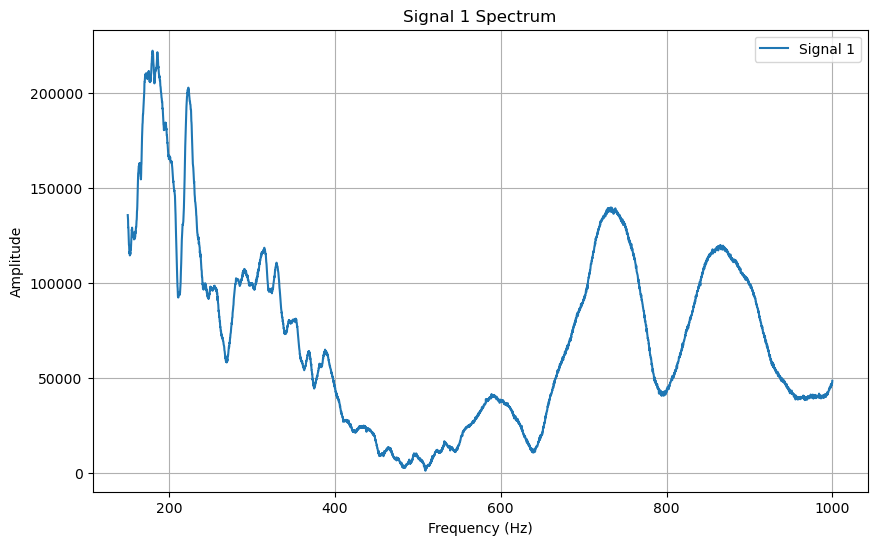

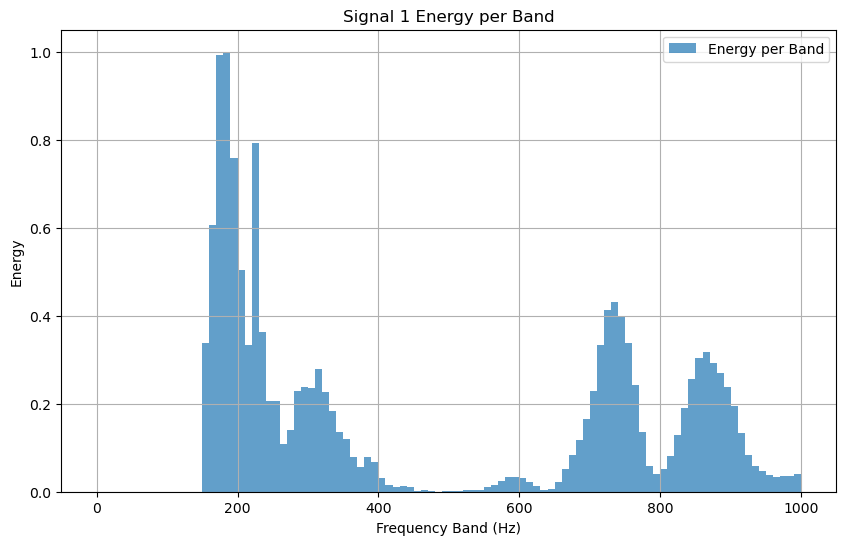

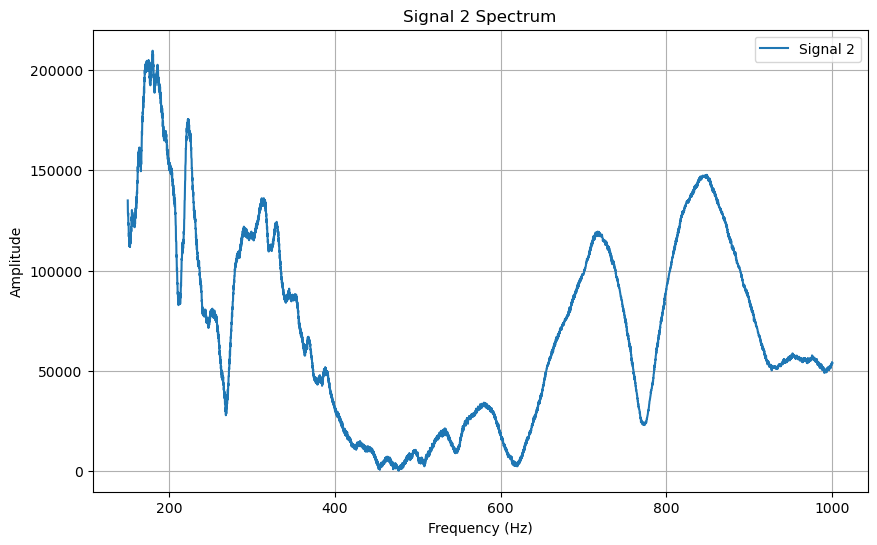

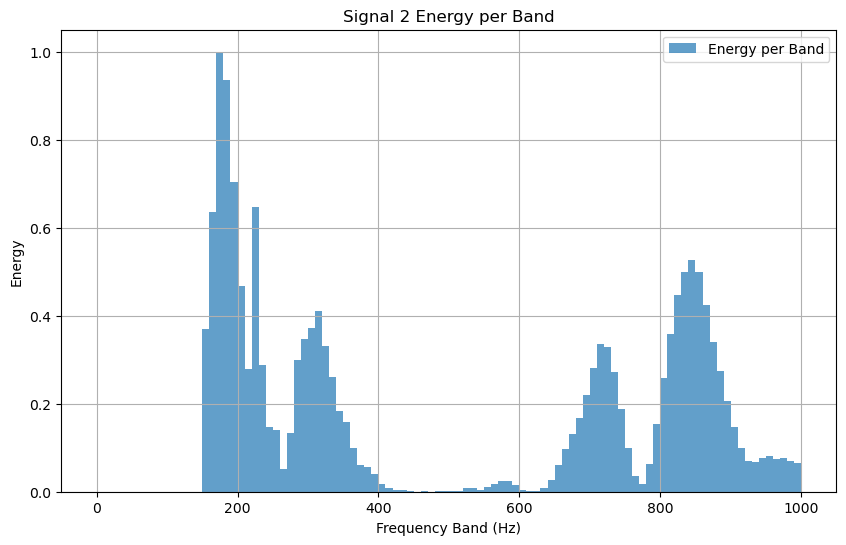

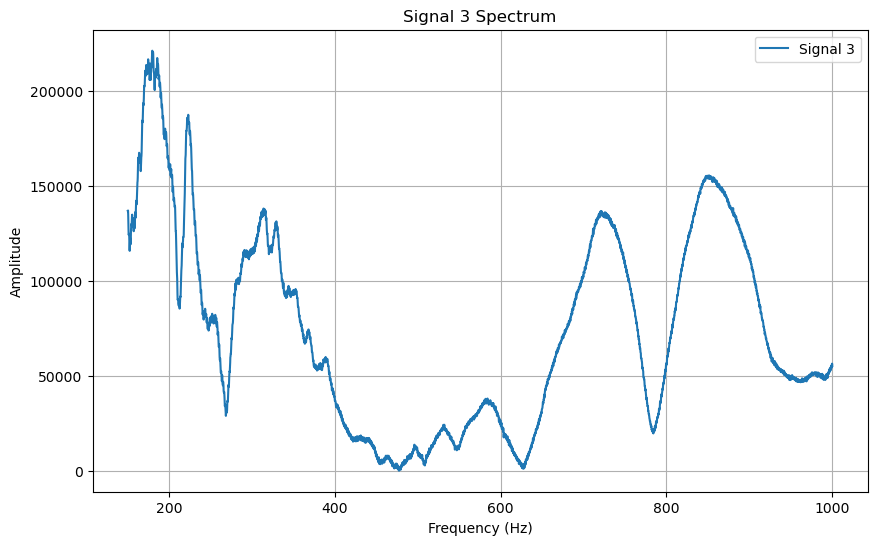

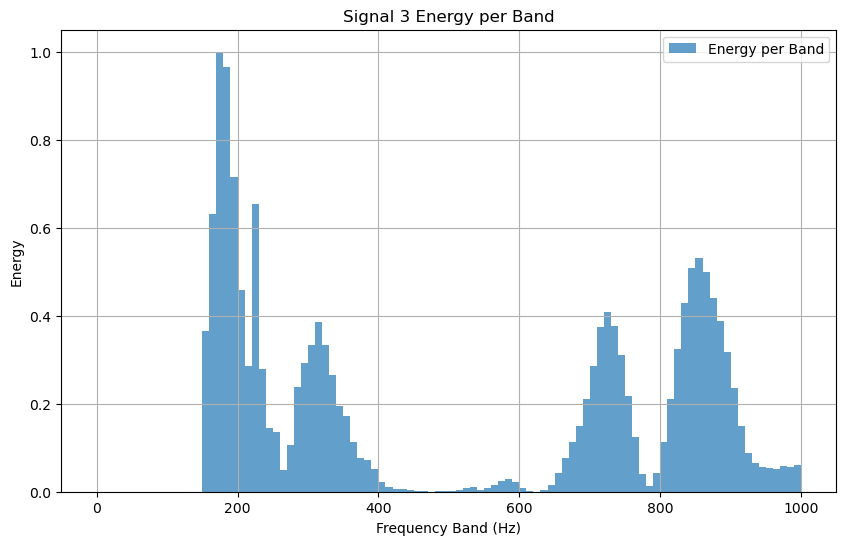

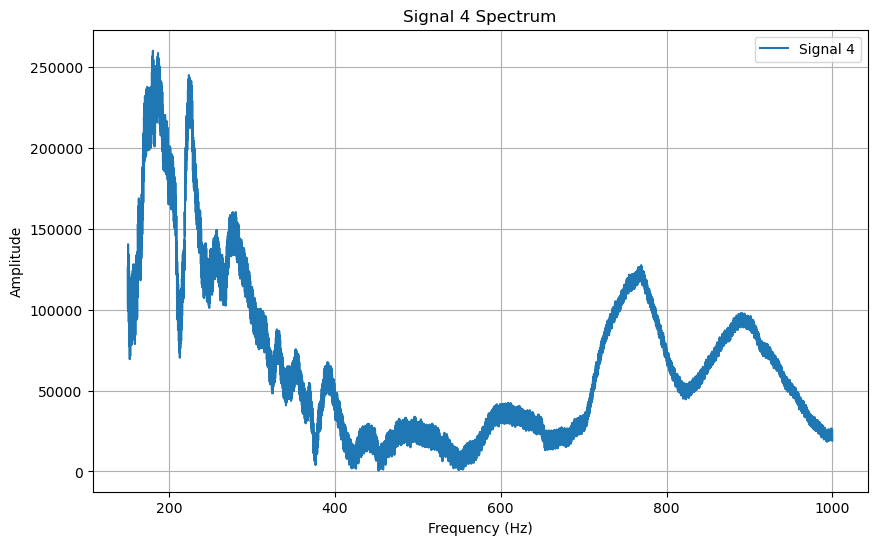

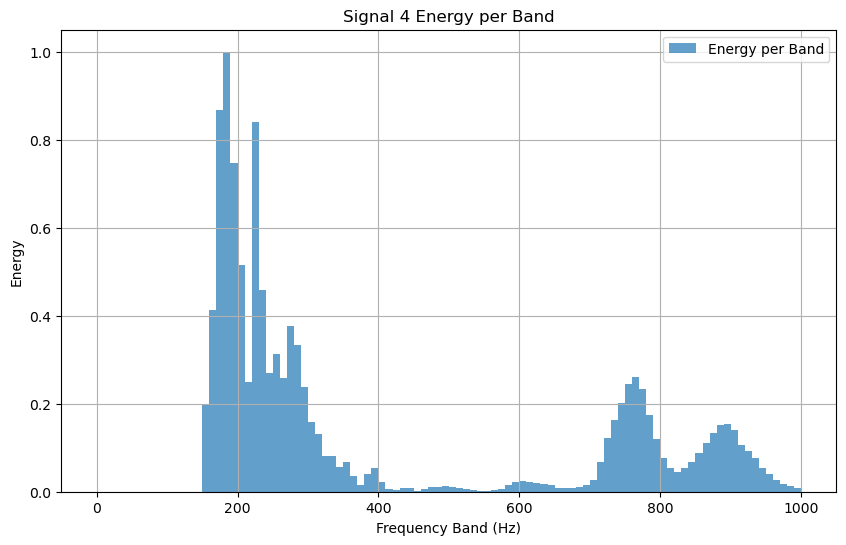

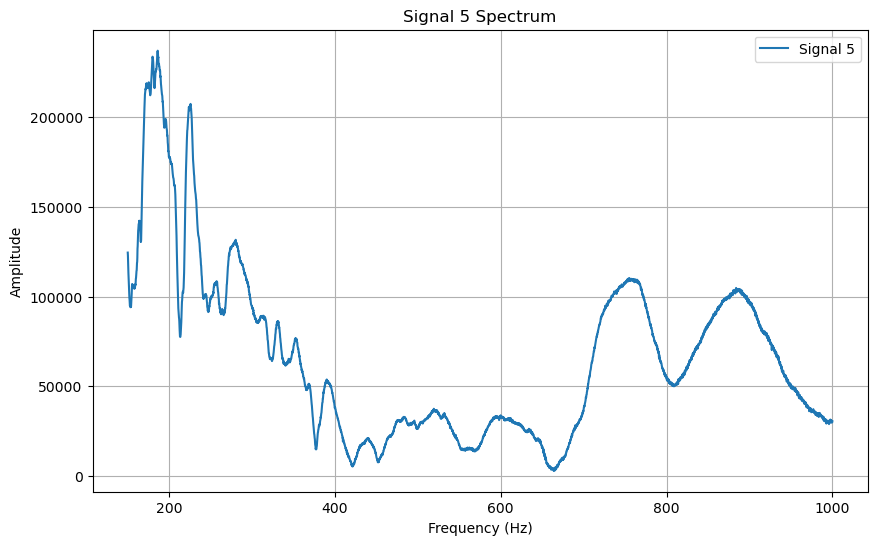

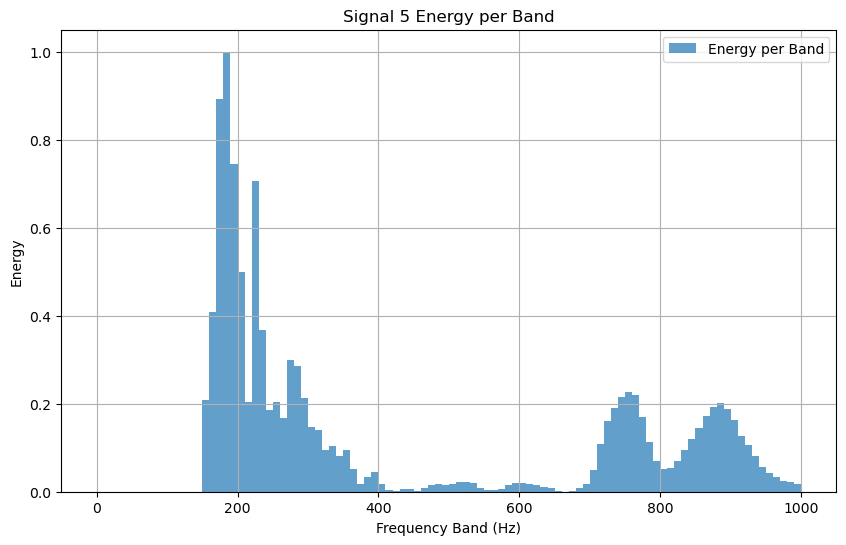

In [3]:
samplerateVect, testWavFileVect, files = readWavFolder("../../../Data/Sound/P1")
print(len(samplerateVect))
for idx in range(5):  # Loop through the first 5 elements
    spectrum, freqs = spectrumFromSignal(testWavFileVect[idx], samplerateVect[idx])
    b_e, b_f = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width=10)
    b_e = b_e / np.max(b_e)
    
    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, spectrum, label=f"Signal {idx + 1}")
    plt.title(f"Signal {idx + 1} Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the energy per band
    plt.figure(figsize=(10, 6))
    plt.bar(b_f, b_e, width=10, alpha=0.7, label="Energy per Band", align='center')
    plt.title(f"Signal {idx + 1} Energy per Band")
    plt.xlabel("Frequency Band (Hz)")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid()
    plt.show()

## Main

In [4]:
results = []

for bw in range(10, 81, 10):
    print(f'bw {bw}')
    X_bandHz = []
    X_bandEnergy=[]
    Y_Label=[]

    samplerateVect,WavFileVect,filesName = readWavFolder("../../../Data/Sound/P1")
    spectrumVect=[]

    for i in range(len(WavFileVect)):
        spectrum, freqs = spectrumFromSignal(WavFileVect[i], samplerateVect[i])

        b_e, b_f = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width=bw)
        X_bandHz.append(b_f)
        X_bandEnergy.append(b_e)
        position=1
        if "C" in filesName[i]:
            position=1
        elif "S" in filesName[i]:
            position=2
        elif "V" in filesName[i]:
            position=3

        Y_Label.append(position)

    X_bandEnergy = [peak_val / np.max(peak_val) for peak_val in X_bandEnergy]

    max_length = max(max(len(p) for p in X_bandHz), max(len(a) for a in X_bandEnergy))
    X_peaksHz_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_bandHz]
    X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_bandEnergy]

    X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        svc = SVC(kernel=kernel)
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred)

        y_train_pred = svc.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)

        results.append({
            'bw': bw,
            'kernel': kernel,
            'accuracy_train': accuracy_train,
            'accuracy_test': accuracy_test
        })

results_df = pd.DataFrame(results)

bw 10
bw 20
bw 30
bw 40
bw 50
bw 60
bw 70
bw 80


### Save the results

In [5]:

if os.path.exists("S_SVM_Position_P1_Energy.xlsx"):
    os.remove("S_SVM_Position_P1_Energy.xlsx")
results_df.to_excel("S_SVM_Position_P1_Energy.xlsx", index=False)
print("Results have been saved to 'S_SVM_Position_P1_Energy.xlsx'.")

Results have been saved to 'S_SVM_Position_P1_Energy.xlsx'.


### Computing the best model

In [6]:
# Get the best configuration
best_config = results_df.loc[results_df['accuracy_test'].idxmax()]
best_accuracy = best_config['accuracy_test']
best_kernel = best_config['kernel']
best_bw = int(best_config['bw'])

print(f"Best Hyperparameters:")
print(f"  accuracy test: {best_accuracy}")
print(f"  kernel: {best_kernel}")
print(f"  bw: {best_bw}")
# Extract features again for the best n_peak
X_bandHz = []
X_bandEnergy = []
Y_Label = []

for i in range(len(WavFileVect)):
    spectrum, freqs = spectrumFromSignal(WavFileVect[i], samplerateVect[i])
    b_e, b_f = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width=bw)
    X_bandHz.append(b_f)
    X_bandEnergy.append(b_e)
    position=1
    if "C" in filesName[i]:
        position=1
    elif "S" in filesName[i]:
        position=2
    elif "V" in filesName[i]:
        position=3
    Y_Label.append(position)
    X_bandEnergy = [peak_val / np.max(peak_val) for peak_val in X_bandEnergy]
    max_length = max(max(len(p) for p in X_bandHz), max(len(a) for a in X_bandEnergy))
    X_peaksHz_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_bandHz]
    X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_bandEnergy]
    X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model with the best configuration
svm_best = SVC(kernel=best_kernel)
svm_best.fit(X_train, y_train)

# Predict and visualize
y_pred_best = svm_best.predict(X_test)

Best Hyperparameters:
  accuracy test: 0.7674418604651163
  kernel: linear
  bw: 50


### Visualisation

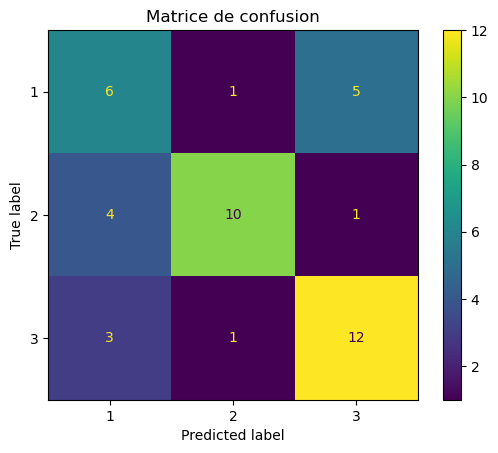

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()